# xgboost

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import datetime
import re

In [2]:
###データ読込(結合したデータ)
train = pd.read_csv("../JLeague/data/train_new4.csv")
test = pd.read_csv("../JLeague/data/test_new4.csv")
player = pd.read_csv("../JLeague/data/player.csv")
test_id = pd.read_csv("../JLeague/motodata/test.csv")["id"]
test_id_all = test["id"]

## Feature Enginiering

In [3]:
def j2num(j):
    return 1 if j == 'Ｊ１' else 0
train["stage"] = train["stage"].map(j2num)
test["stage"] = test["stage"].map(j2num)

In [4]:
for i, weather in enumerate(train["weather"]):
    weather = str(weather)
    if re.match("雨", weather):
        train.ix[i, "rain"] = 1
    else:
        train.ix[i, "rain"] = 0
for i, weather in enumerate(test["weather"]):
    weather = str(weather)
    if re.match("雨", weather):
        test.ix[i, "rain"] = 1
    else:
        test.ix[i, "rain"] = 0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


In [5]:
for i, m in enumerate(train["match"]):
    match = re.findall("第(\w+)節第(\w+)日", str(m))[0]
    train.ix[i, "section"] = int(match[0])
    train.ix[i, "no"] = int(match[1])
for i, m in enumerate(test["match"]):
    match = re.findall("第(\w+)節第(\w+)日", str(m))[0]
    test.ix[i, "section"] = int(match[0])
    test.ix[i, "no"] = int(match[1])

In [6]:
if (train.stage[0] == 1):
    train["sec_diff"] = np.abs(train["section"] - 17)**2
    test["sec_diff"] = np.abs(test["section"] - 17)**2
else:
    train["sec_diff"] = np.abs(train["section"] - 21)**2
    test["sec_diff"] = np.abs(test["section"] - 21)**2

In [7]:
for i, tv in enumerate(train["tv"]):
    tv = str(tv)
    tvlist = tv.split("／")
    train.ix[i, "media"] = int(len(tvlist))
for i, tv in enumerate(test["tv"]):
    tv = str(tv)
    tvlist = tv.split("／")
    test.ix[i, "media"] = int(len(tvlist))

In [8]:
for i, day in enumerate(train["gameday"]):
    day = str(day)
    train.ix[i, "month"] = int(day[:2])
    train.ix[i, "day"] = int(day[3:5])
    weekday = day[5:]
    if re.match("\(\w・祝\)", weekday):
        train.ix[i, "weekday"] = 0
    elif re.match("\(\w・休\)", weekday):
        train.ix[i, "weekday"] = 0
    elif weekday == "(土)":
        train.ix[i, "weekday"] = 1
    elif weekday == "(日)":
        train.ix[i, "weekday"] = 2
    else:
        train.ix[i, "weekday"] = 3
for i, day in enumerate(test["gameday"]):
    day = str(day)
    test.ix[i, "month"] = int(day[:2])
    test.ix[i, "day"] = int(day[3:5])
    weekday = day[5:]
    if re.match("\(\w・祝\)", weekday):
        test.ix[i, "weekday"] = 0
    elif re.match("\(\w・休\)", weekday):
        test.ix[i, "weekday"] = 0
    elif weekday == "(土)":
        test.ix[i, "weekday"] = 1
    elif weekday == "(日)":
        test.ix[i, "weekday"] = 2
    else:
        test.ix[i, "weekday"] = 3

In [9]:
from dateutil.parser import parse
for i, t in enumerate(train["time"]):
    train.ix[i, "hour"] = int(str(t)[:2])
for i, t in enumerate(test["time"]):
    test.ix[i, "hour"] = int(str(t)[:2])

In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train["home"])
train["home"] = le.transform(train["home"])
train["away"] = le.transform(train["away"])
test["home"] = le.transform(test["home"])
test["away"] = le.transform(test["away"])

In [11]:
for i, t in enumerate(train["humidity"]):
    train.ix[i, "humid"] = int(str(t)[:2])
for i, t in enumerate(test["humidity"]):
    test.ix[i, "humid"] = int(str(t)[:2])

In [12]:
def discomfort_index(T, H):
    return 0.81*T+0.01*H*(0.99*T - 14.3) + 46.3
train["discomfort"] = discomfort_index(train["temperature"], train["humid"])
test["discomfort"] = discomfort_index(test["temperature"], test["humid"])

In [13]:
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(train[column]):
        salary = player[player.player_name==name].annual_salary.values
        train.ix[row, column] = 2500000 if salary.size == 0 else salary
    column = "away_%02d" % i
    for row, name in enumerate(train[column]):
        salary = player[player.player_name==name].annual_salary.values
        train.ix[row, column] = 2500000 if salary.size == 0 else salary
for i in range(1,12):
    column = "home_%02d" % i
    for row, name in enumerate(test[column]):
        salary = player[player.player_name==name].annual_salary.values
        test.ix[row, column] = 2500000 if salary.size == 0 else salary
    column = "away_%02d" % i
    for row, name in enumerate(test[column]):
        salary = player[player.player_name==name].annual_salary.values
        test.ix[row, column] = 2500000 if salary.size == 0 else salary

In [14]:
train["home_all"] = train[["home_01","home_02","home_03","home_04","home_05","home_06","home_07","home_08","home_09","home_10","home_11"]].sum(axis=1) 
train["away_all"] = train[["away_01","away_02","away_03","away_04","away_05","away_06","away_07","away_08","away_09","away_10","away_11"]].sum(axis=1) 
test["home_all"] = test[["home_01","home_02","home_03","home_04","home_05","home_06","home_07","home_08","home_09","home_10","home_11"]].sum(axis=1) 
test["away_all"] = test[["away_01","away_02","away_03","away_04","away_05","away_06","away_07","away_08","away_09","away_10","away_11"]].sum(axis=1) 

In [101]:
train1 = train[["y", "capa", "home_score", "away_score", "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all", "stage", "specific", "latitude", "longitude", "population", "area", "dencity", "rain","sec_diff"]]
test1 = test[["capa", "home_score", "away_score",  "month", "day", "weekday", "home", "away", "media", "discomfort", "temperature", "humid", "home_all", "away_all", "stage", "specific", "latitude", "longitude", "population", "area", "dencity", "rain", "sec_diff"]]
target = 'y'

## param tuning

In [16]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [219]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='rmse', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        
    X_train, X_test, y_train, y_test = train_test_split(dtrain[predictors].values, dtrain[target].values, test_size=0.2, random_state=17)
        
    #Fit the algorithm on the data
    alg.fit(X_train, y_train, eval_metric='rmse')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X_test)
        
    #Print model report:
    print("\nModel Report")
    print("RMSE Score (Train): %f" % np.sqrt(mean_squared_error(y_test, dtrain_predictions)))

In [220]:
#Choose all predictors except target & IDcols
predictors = [x for x in train1.columns if x not in ["y"]]

In [221]:
xgb1 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 eval_metrics=RMSE,
 seed=17)
modelfit(xgb1, train1, predictors, useTrainCV=True)


Model Report
RMSE Score (Train): 2684.095309


In [ ]:
def fmean_squared_error(ground_truth, predictions):
    fmean_squared_error_ = mean_squared_error(ground_truth, predictions)**0.5
    return fmean_squared_error_

RMSE  = make_scorer(fmean_squared_error, greater_is_better=False)

In [121]:
param_test1 = {
 'max_depth':[3,5,7,9],
 'min_child_weight':[1,3,5]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=RMSE,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors],train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3196.04514, std: 736.03085, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -3205.01817, std: 742.75090, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -3198.90159, std: 739.02122, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -3158.42656, std: 799.55816, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -3174.53808, std: 810.92791, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: -3138.77363, std: 784.09367, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -3220.92199, std: 822.76959, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: -3169.33365, std: 821.55430, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: -3171.97271, std: 764.77003, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -3265.86392, std: 841.47788, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: -3211.69494, std: 836.71427, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: -3208.90700, std: 800.26452, params: {'max_dep

In [86]:
param_test1 = {
 'max_depth':[5],
 'min_child_weight':[4,5,6]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=RMSE,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors], train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3182.22805, std: 822.34231, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: -3138.77363, std: 784.09367, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: -3154.22717, std: 790.61725, params: {'max_depth': 5, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 5},
 -3138.773631566328)

In [55]:
param_test1 = {
    'gamma':[i/10.0 for i in range(0,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=grid_scorer,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors], train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3138.77363, std: 784.09367, params: {'gamma': 0.0},
  mean: -3138.77363, std: 784.09367, params: {'gamma': 0.1},
  mean: -3138.77363, std: 784.09367, params: {'gamma': 0.2},
  mean: -3138.77363, std: 784.09367, params: {'gamma': 0.3},
  mean: -3138.77363, std: 784.09367, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -3138.773631566328)

In [87]:
#Choose all predictors except target & IDcols
predictors = [x for x in train1.columns if x not in ["y"]]
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 eval_metrics=grid_scorer,
 seed=17)
modelfit(xgb2, train1, predictors, useTrainCV=True)


Model Report
RMSE Score (Train): 2744.010955


In [89]:
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=RMSE,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors], train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3139.55484, std: 761.84842, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -3112.24695, std: 773.86324, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -3112.86674, std: 742.97115, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -3128.71791, std: 756.66045, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: -3145.24164, std: 777.68326, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -3135.17838, std: 778.15666, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -3151.50547, std: 749.26969, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -3131.22972, std: 780.86352, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: -3188.19891, std: 767.07586, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -3132.77486, std: 771.38023, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -3138.77363, std: 784.09367, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: -3

In [102]:
param_test1 = {
 'subsample':[i/100.0 for i in range(65,80,5)],
 'colsample_bytree':[i/100.0 for i in range(65,80,5)]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=RMSE,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors], train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3145.83464, std: 781.86836, params: {'subsample': 0.65, 'colsample_bytree': 0.65},
  mean: -3138.35928, std: 744.42745, params: {'subsample': 0.7, 'colsample_bytree': 0.65},
  mean: -3130.29991, std: 731.24170, params: {'subsample': 0.75, 'colsample_bytree': 0.65},
  mean: -3173.45303, std: 798.71541, params: {'subsample': 0.65, 'colsample_bytree': 0.7},
  mean: -3157.11462, std: 784.24426, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -3141.44151, std: 758.14281, params: {'subsample': 0.75, 'colsample_bytree': 0.7},
  mean: -3199.36621, std: 772.12498, params: {'subsample': 0.65, 'colsample_bytree': 0.75},
  mean: -3115.50293, std: 756.23197, params: {'subsample': 0.7, 'colsample_bytree': 0.75},
  mean: -3147.14634, std: 764.89481, params: {'subsample': 0.75, 'colsample_bytree': 0.75}],
 {'colsample_bytree': 0.75, 'subsample': 0.7},
 -3115.50293286631)

In [222]:
xgb2 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.75,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 eval_metrics=RMSE,
 seed=17)
modelfit(xgb2, train1, predictors, useTrainCV=True)


Model Report
RMSE Score (Train): 2817.514586


In [110]:
param_test1 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=5, gamma=0, subsample=0.7, colsample_bytree=0.75,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=RMSE,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors], train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3091.97072, std: 780.22306, params: {'reg_alpha': 1e-05},
  mean: -3091.97075, std: 780.22311, params: {'reg_alpha': 0.01},
  mean: -3093.13497, std: 778.71077, params: {'reg_alpha': 0.1},
  mean: -3093.13643, std: 778.71105, params: {'reg_alpha': 1},
  mean: -3083.71710, std: 753.72572, params: {'reg_alpha': 100}],
 {'reg_alpha': 100},
 -3083.71710061901)

In [114]:
param_test1 = {
 'reg_alpha':[140,150,160]
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
                                                min_child_weight=5, gamma=0, subsample=0.7, colsample_bytree=0.75,
                                                objective= 'reg:linear', nthread=1, scale_pos_weight=1, seed=17),
                                                param_grid = param_test1, scoring=RMSE,n_jobs=4,iid=False, cv=5)
gsearch1.fit(train1[predictors], train1[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -3119.26512, std: 740.18374, params: {'reg_alpha': 140},
  mean: -3079.47545, std: 735.54530, params: {'reg_alpha': 150},
  mean: -3098.34248, std: 754.96094, params: {'reg_alpha': 160}],
 {'reg_alpha': 150},
 -3079.475449411656)

In [223]:
xgb3 = XGBRegressor(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.75,
 reg_alpha=150,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 eval_metrics=RMSE,
 seed=17)
modelfit(xgb3, train1, predictors, useTrainCV=True)


Model Report
RMSE Score (Train): 2713.984887


In [224]:
xgb4 = XGBRegressor(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=5,
 gamma=0,
 subsample=0.7,
 colsample_bytree=0.75,
 reg_alpha=150,
 objective= 'reg:linear',
 nthread=4,
 scale_pos_weight=1,
 eval_metrics=RMSE,
 seed=17)
modelfit(xgb4, train1, predictors, useTrainCV=True)


Model Report
RMSE Score (Train): 2774.044158


## evaluate

In [225]:
y1 = train1["y"]
train1 = train1.drop(["y"], axis=1)

In [226]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train1, y1, test_size=0.2, random_state=17)

In [258]:
model = XGBRegressor(eval_metrics='rmse', random_state=17)
xgb4.fit(X_train, y_train, eval_metric='rmse')

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75,
       eval_metrics=make_scorer(fmean_squared_error, greater_is_better=False),
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
       nthread=4, objective='reg:linear', random_state=0, reg_alpha=150,
       reg_lambda=1, scale_pos_weight=1, seed=17, silent=True,
       subsample=0.7)

In [259]:
pred = xgb4.predict(X_test)

In [260]:
np.sqrt(mean_squared_error(y_test, pred))

2774.0441583396655

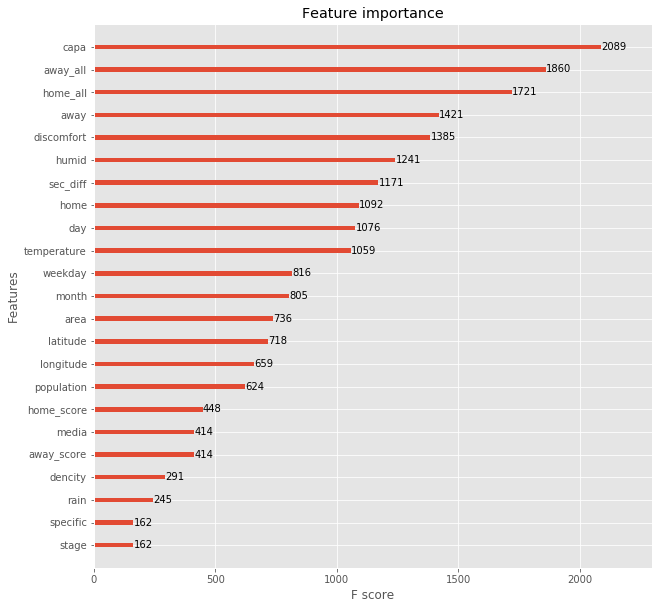

In [261]:
plt.style.use('ggplot')
ax = xgb.plot_importance(xgb4)
fig = ax.figure
fig.set_size_inches(10, 10)

## submit

In [262]:
pred = xgb4.predict(test1)

In [263]:
for i, p in enumerate(pred):
    if p > test1.ix[i, "capa"]:
        pred[i] = test1.ix[i, "capa"]
    else:
        pred[i] = p

In [264]:
for i, p in enumerate(pred):
    if p < min(y1):
        print(p, min(y1))
        pred[i] = min(y1)
    else:
        pred[i] = p

In [265]:
pred = pd.DataFrame(pred, columns={"pred"})
pred["id"] = test_id_all

In [266]:
test_id = pd.DataFrame(test_id)
test_id["id"] = test_id

In [267]:
pred = pd.merge(pred, test_id, how="right", on=["id"])

In [268]:
pred = pred.loc[:, ["id", "pred"]]

In [269]:
pred.to_csv("../JLeague/submit/submit_1127_2_xgboost.csv", index=False, header=False)